In [21]:
from DCC import *
from Utils import *
from Plots import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [22]:
init_plotting()

In [23]:
dataset2name = {
    "Bala_classification_dataset.csv": "Bala Classification",
    "Bala_regression_dataset.csv": "Bala Regression",
    "bandgap.csv": "Bandgap",
    "BMDS_data.csv": "BMDS",
    "Crystal_structure.csv": "Crystal Structure",
    "Glass.csv": "Glass",
    "PUE.csv": "PUE",
}

In [24]:
from pathlib import Path

dataset_dir = Path("processed_data")

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from joblib import Parallel, delayed

dataset_dir = Path("processed_data")
datasets = list(dataset_dir.glob("*.csv"))
dataset_config = {
    "Bala_classification_dataset.csv": {
        "target_cols": ["Formability"],
        "type": "classification",
    },
    "Bala_regression_dataset.csv": {
        "target_cols": ["Ferroelectric_Tc_in_Kelvin"],
        "type": "regression",
    },
    "bandgap.csv": {
        "target_cols": ["target"],
        "type": "regression",
    },
    "BMDS_data.csv": {
        "target_cols": ["soc_bandgap"],
        "type": "regression",
    },
    "Crystal_structure.csv": {
        "target_cols": ["Lowest distortion"],
        "type": "classification",
    },
    "Glass.csv": {
        "target_cols": ["Type of glass"],
        "type": "classification",
    },
    "PUE.csv": {
        "target_cols": ["logYM"],
        "type": "regression",
    },
}


def get_scores(X, y, target_cols, type, state=42):
    cur_scores = []
    n_splits = 5
    if type == "classification":
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=state)
    else:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=state)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if type == "regression":
            model = RandomForestRegressor(n_estimators=500, random_state=42)
        elif type == "classification":
            model = RandomForestClassifier(n_estimators=500, random_state=42)
        else:
            raise ValueError("type must be either 'regression' or 'classification'")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if type == "regression":
            cur_scores.append(r2_score(y_test, y_pred))
        elif type == "classification":
            cur_scores.append(accuracy_score(y_test, y_pred))
    return np.array(cur_scores)


def model_performace_exp(df, name, target_cols, type):
    print(name)
    X = df.drop(columns=target_cols)
    all_scores = {}
    for target_col in target_cols:
        scores = []
        y = df[target_col]
        scores = Parallel(n_jobs=-1)(
            delayed(get_scores)(X, y, [target_col], type, state) for state in range(50)
        )
        scores = np.array(scores)
        all_scores[target_col] = scores
    return all_scores

In [26]:
from pathlib import Path
from collections import defaultdict

results = defaultdict(dict)

In [27]:
for d in dataset_dir.glob("*.csv"):
    df = pd.read_csv(d)
    df = df.select_dtypes(include=[np.number])
    target_cols = dataset_config[d.name]["target_cols"]
    type = dataset_config[d.name]["type"]
    performace_scores = model_performace_exp(df, d.name, target_cols, type)
    print(f"Dataset: {d.name}, Type: {type}")
    for target_col, score in performace_scores.items():
        print(f"Target column: {target_col}, Scores: {score}")
        print(f"Mean score: {np.mean(score)}, Std score: {np.std(score)}")
        results[f"{d.name}_{target_col}"]["model_scores"] = {
            "type": type,
            "scores": score,
            "mean": np.mean(score),
            "std": np.std(score),
        }

Bala_classification_dataset.csv
Dataset: Bala_classification_dataset.csv, Type: classification
Target column: Formability, Scores: [[0.97435897 0.92307692 0.86842105 0.92105263 0.78947368]
 [0.87179487 0.92307692 0.89473684 0.94736842 0.84210526]
 [0.92307692 0.84615385 0.86842105 0.94736842 0.89473684]
 [0.94871795 0.79487179 0.94736842 0.84210526 0.97368421]
 [0.8974359  0.82051282 0.89473684 0.89473684 0.92105263]
 [0.94871795 0.82051282 0.89473684 1.         0.76315789]
 [0.79487179 0.92307692 0.89473684 0.81578947 0.89473684]
 [0.8974359  0.84615385 0.97368421 0.89473684 0.89473684]
 [0.8974359  0.94871795 0.84210526 0.89473684 0.86842105]
 [0.84615385 0.87179487 0.94736842 0.94736842 0.92105263]
 [0.87179487 0.94871795 0.86842105 0.97368421 0.94736842]
 [0.8974359  0.92307692 0.89473684 0.92105263 0.86842105]
 [0.74358974 0.84615385 0.94736842 0.84210526 0.89473684]
 [0.92307692 0.8974359  0.89473684 0.92105263 0.89473684]
 [0.8974359  0.84615385 0.92105263 0.92105263 0.86842105]

KeyboardInterrupt: 

In [ ]:
corr_func = spearman_matrix
def exp(df, name, ax, show_xlabel, show_ylabel):
    n, m = df.shape
    print(f"Number of samples: {n}, Number of features: {m}")
    # df_rnd = pd.DataFrame(np.random.rand(n // 2, m), columns=df.columns)
    df_rnd = generate_random_according_df(n // 2, m, df)
    df_linear = generate_linear_according_df(n // 2, m, df)

    # dcc vs 扰动的数据占比
    fig = plt.figure(figsize=(10, 8))
    # 扰动为drop数据
    dcc_scores_drop = []

    thetas = np.linspace(0.0, 0.50, 10)
    auc_scores = []
    for _ in range(5):
        dcc_scores_real_data = []

        for t in thetas:
            dcc_scores_real_data.append(repeated_avg_dcc(data=df, ratio=t, eps=0.04, corr_func=corr_func))
        dcc_scores_drop.append(dcc_scores_real_data)
        # plot
        area_scores = calculate_area_under_curve(dcc_scores_real_data, thetas)
        auc_scores.append(area_scores)
        # print(f"Area under curve for real data in dcc vs theta: {area_scores}")
    dcc_scores_drop = np.array(dcc_scores_drop)
    ax.errorbar(
        thetas,
        dcc_scores_drop.mean(axis=0),
        yerr=dcc_scores_drop.std(axis=0),
        capsize=5,
        fmt="o",
        markersize=5,
        elinewidth=2,
        markeredgewidth=2,
        color="#ff595f",
    )
    ax.plot(thetas, dcc_scores_drop.mean(axis=0), label="Drop Data", color="#ff595e")

    n_parts = 10

    # 将扰动方式改为添加数据
    dcc_scores_append_linears = []
    dcc_scores_append_randoms = []
    append_samples_ratios = [0]  # Define outside the loop to ensure it's always defined
    for _ in range(5):
        dcc_scores_append_linear = [1.0]
        df_cur = df.copy()
        ori_samples = df.shape[0]
        append_samples_ratios = [0]  # Reset for each iteration
        # shuffle the df_linear and df_rnd
        df_linear = df_linear.sample(frac=1.0).reset_index(drop=True)
        df_rnd = df_rnd.sample(frac=1.0).reset_index(drop=True)
        for i, part in enumerate(split_dataframe(df_linear, n_parts=n_parts)):
            df_cur = pd.concat([df_cur, part])
            append_samples = df_cur.shape[0] - ori_samples
            append_samples_ratios.append(append_samples / ori_samples)
            dcc_scores_append_linear.append(dcc_diff(df, df_cur, eps=0.04, corr_func=corr_func))
        dcc_scores_append_random = [1.0]
        df_cur = df.copy()
        for i, part in enumerate(split_dataframe(df_rnd, n_parts=n_parts)):
            df_cur = pd.concat([df_cur, part])
            dcc_scores_append_random.append(dcc_diff(df, df_cur, eps=0.04, corr_func=corr_func))
        dcc_scores_append_linears.append(dcc_scores_append_linear)
        dcc_scores_append_randoms.append(dcc_scores_append_random)
    dcc_scores_append_linears = np.array(dcc_scores_append_linears)
    dcc_scores_append_randoms = np.array(dcc_scores_append_randoms)

    ax.errorbar(
        append_samples_ratios,
        dcc_scores_append_linears.mean(axis=0),
        yerr=dcc_scores_append_linears.std(axis=0),
        capsize=5,
        fmt="o",
        markersize=5,
        elinewidth=2,
        markeredgewidth=2,
        color="#ffca3a",
    )
    ax.plot(
        append_samples_ratios,
        dcc_scores_append_linears.mean(axis=0),
        label="Append Linear Data",
        color="#ffca3a",
        linestyle="--",
    )
    ax.errorbar(
        append_samples_ratios,
        dcc_scores_append_randoms.mean(axis=0),
        yerr=dcc_scores_append_randoms.std(axis=0),
        capsize=5,
        fmt="o",
        markersize=5,
        elinewidth=2,
        markeredgewidth=2,
        color="#8ac926",
    )
    ax.plot(
        append_samples_ratios,
        dcc_scores_append_randoms.mean(axis=0),
        label="Append Random Data",
        color="#8ac926",
        linestyle="--",
    )

    # 将扰动方式改为替换数据
    dcc_scores_replace_linears = []
    dcc_scores_replace_randoms = []
    replace_ratios = [0]  # Define outside the loop to ensure it's always defined
    for _ in range(5):
        df_replace = pd.DataFrame()
        dcc_scores_replace_linear = [1.0]
        replace_ratios = [0]
        # shuffle the df_linear and df_rnd
        df_linear = df_linear.sample(frac=1.0).reset_index(drop=True)
        df_rnd = df_rnd.sample(frac=1.0).reset_index(drop=True)

        for i, part in enumerate(split_dataframe(df_linear, n_parts=n_parts)):
            df_replace = pd.concat([df_replace, part])
            df_cur = random_replace_rows(df, df_replace)
            replace_ratios.append(df_replace.shape[0] / df.shape[0])
            dcc_scores_replace_linear.append(dcc_diff(df, df_cur, eps=0.04, corr_func=corr_func))

        dcc_scores_replace_random = [1.0]
        df_replace = pd.DataFrame()
        for i, part in enumerate(split_dataframe(df_rnd, n_parts=n_parts)):
            df_replace = pd.concat([df_replace, part])
            df_cur = random_replace_rows(df, df_replace)
            dcc_scores_replace_random.append(dcc_diff(df, df_cur, eps=0.04, corr_func=corr_func))

        dcc_scores_replace_linears.append(dcc_scores_replace_linear)
        dcc_scores_replace_randoms.append(dcc_scores_replace_random)
    dcc_scores_replace_linears = np.array(dcc_scores_replace_linears)
    dcc_scores_replace_randoms = np.array(dcc_scores_replace_randoms)

    ax.errorbar(
        replace_ratios,
        dcc_scores_replace_linears.mean(axis=0),
        yerr=dcc_scores_replace_linears.std(axis=0),
        capsize=5,
        fmt="o",
        markersize=5,
        elinewidth=2,
        markeredgewidth=2,
        color="#1982c4",
        alpha=0.6,
    )
    ax.plot(
        replace_ratios,
        dcc_scores_replace_linears.mean(axis=0),
        label="Replace Linear Data",
        color="#1982c4",
        linestyle="dotted",
        alpha=0.6,
    )
    ax.errorbar(
        replace_ratios,
        dcc_scores_replace_randoms.mean(axis=0),
        yerr=dcc_scores_replace_randoms.std(axis=0),
        capsize=5,
        fmt="o",
        markersize=5,
        elinewidth=2,
        markeredgewidth=2,
        color="#6a4c93",
        alpha=0.6,
    )
    ax.plot(
        replace_ratios,
        dcc_scores_replace_randoms.mean(axis=0),
        label="Replace Random Data",
        color="#6a4c93",
        linestyle="dotted",
        alpha=0.6,
    )
    # ax.set_ylim(-0.05, 1.05)
    if show_xlabel:
        ax.set_xlabel(r"Perturbation Ratio $\theta$")
    else:
        ax.set_xlabel("")
    if show_ylabel:
        ax.set_ylabel("DCC")
    else:
        ax.set_ylabel("")
    # ax.title.set_text(dataset2name[name])
    # add title inside 
    ax.text(
        0.8,
        0.85,
        f"{dataset2name[name]}\n N:{df.shape[0]}",
        horizontalalignment="center",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=24,
        fontweight="bold",
    )
    return (
        auc_scores,
        dcc_scores_drop.mean(axis=0),
        dcc_scores_append_randoms.mean(axis=0),
        dcc_scores_append_linears.mean(axis=0),
        dcc_scores_replace_randoms.mean(axis=0),
        dcc_scores_replace_linears.mean(axis=0),
    )

Found 7 datasets in processed_data
Rows: 4, Cols: 2
Number of samples: 132, Number of features: 6
Number of samples: 192, Number of features: 14
Number of samples: 214, Number of features: 10
Number of samples: 326, Number of features: 21
Number of samples: 675, Number of features: 14
Number of samples: 760, Number of features: 13
Number of samples: 2483, Number of features: 13


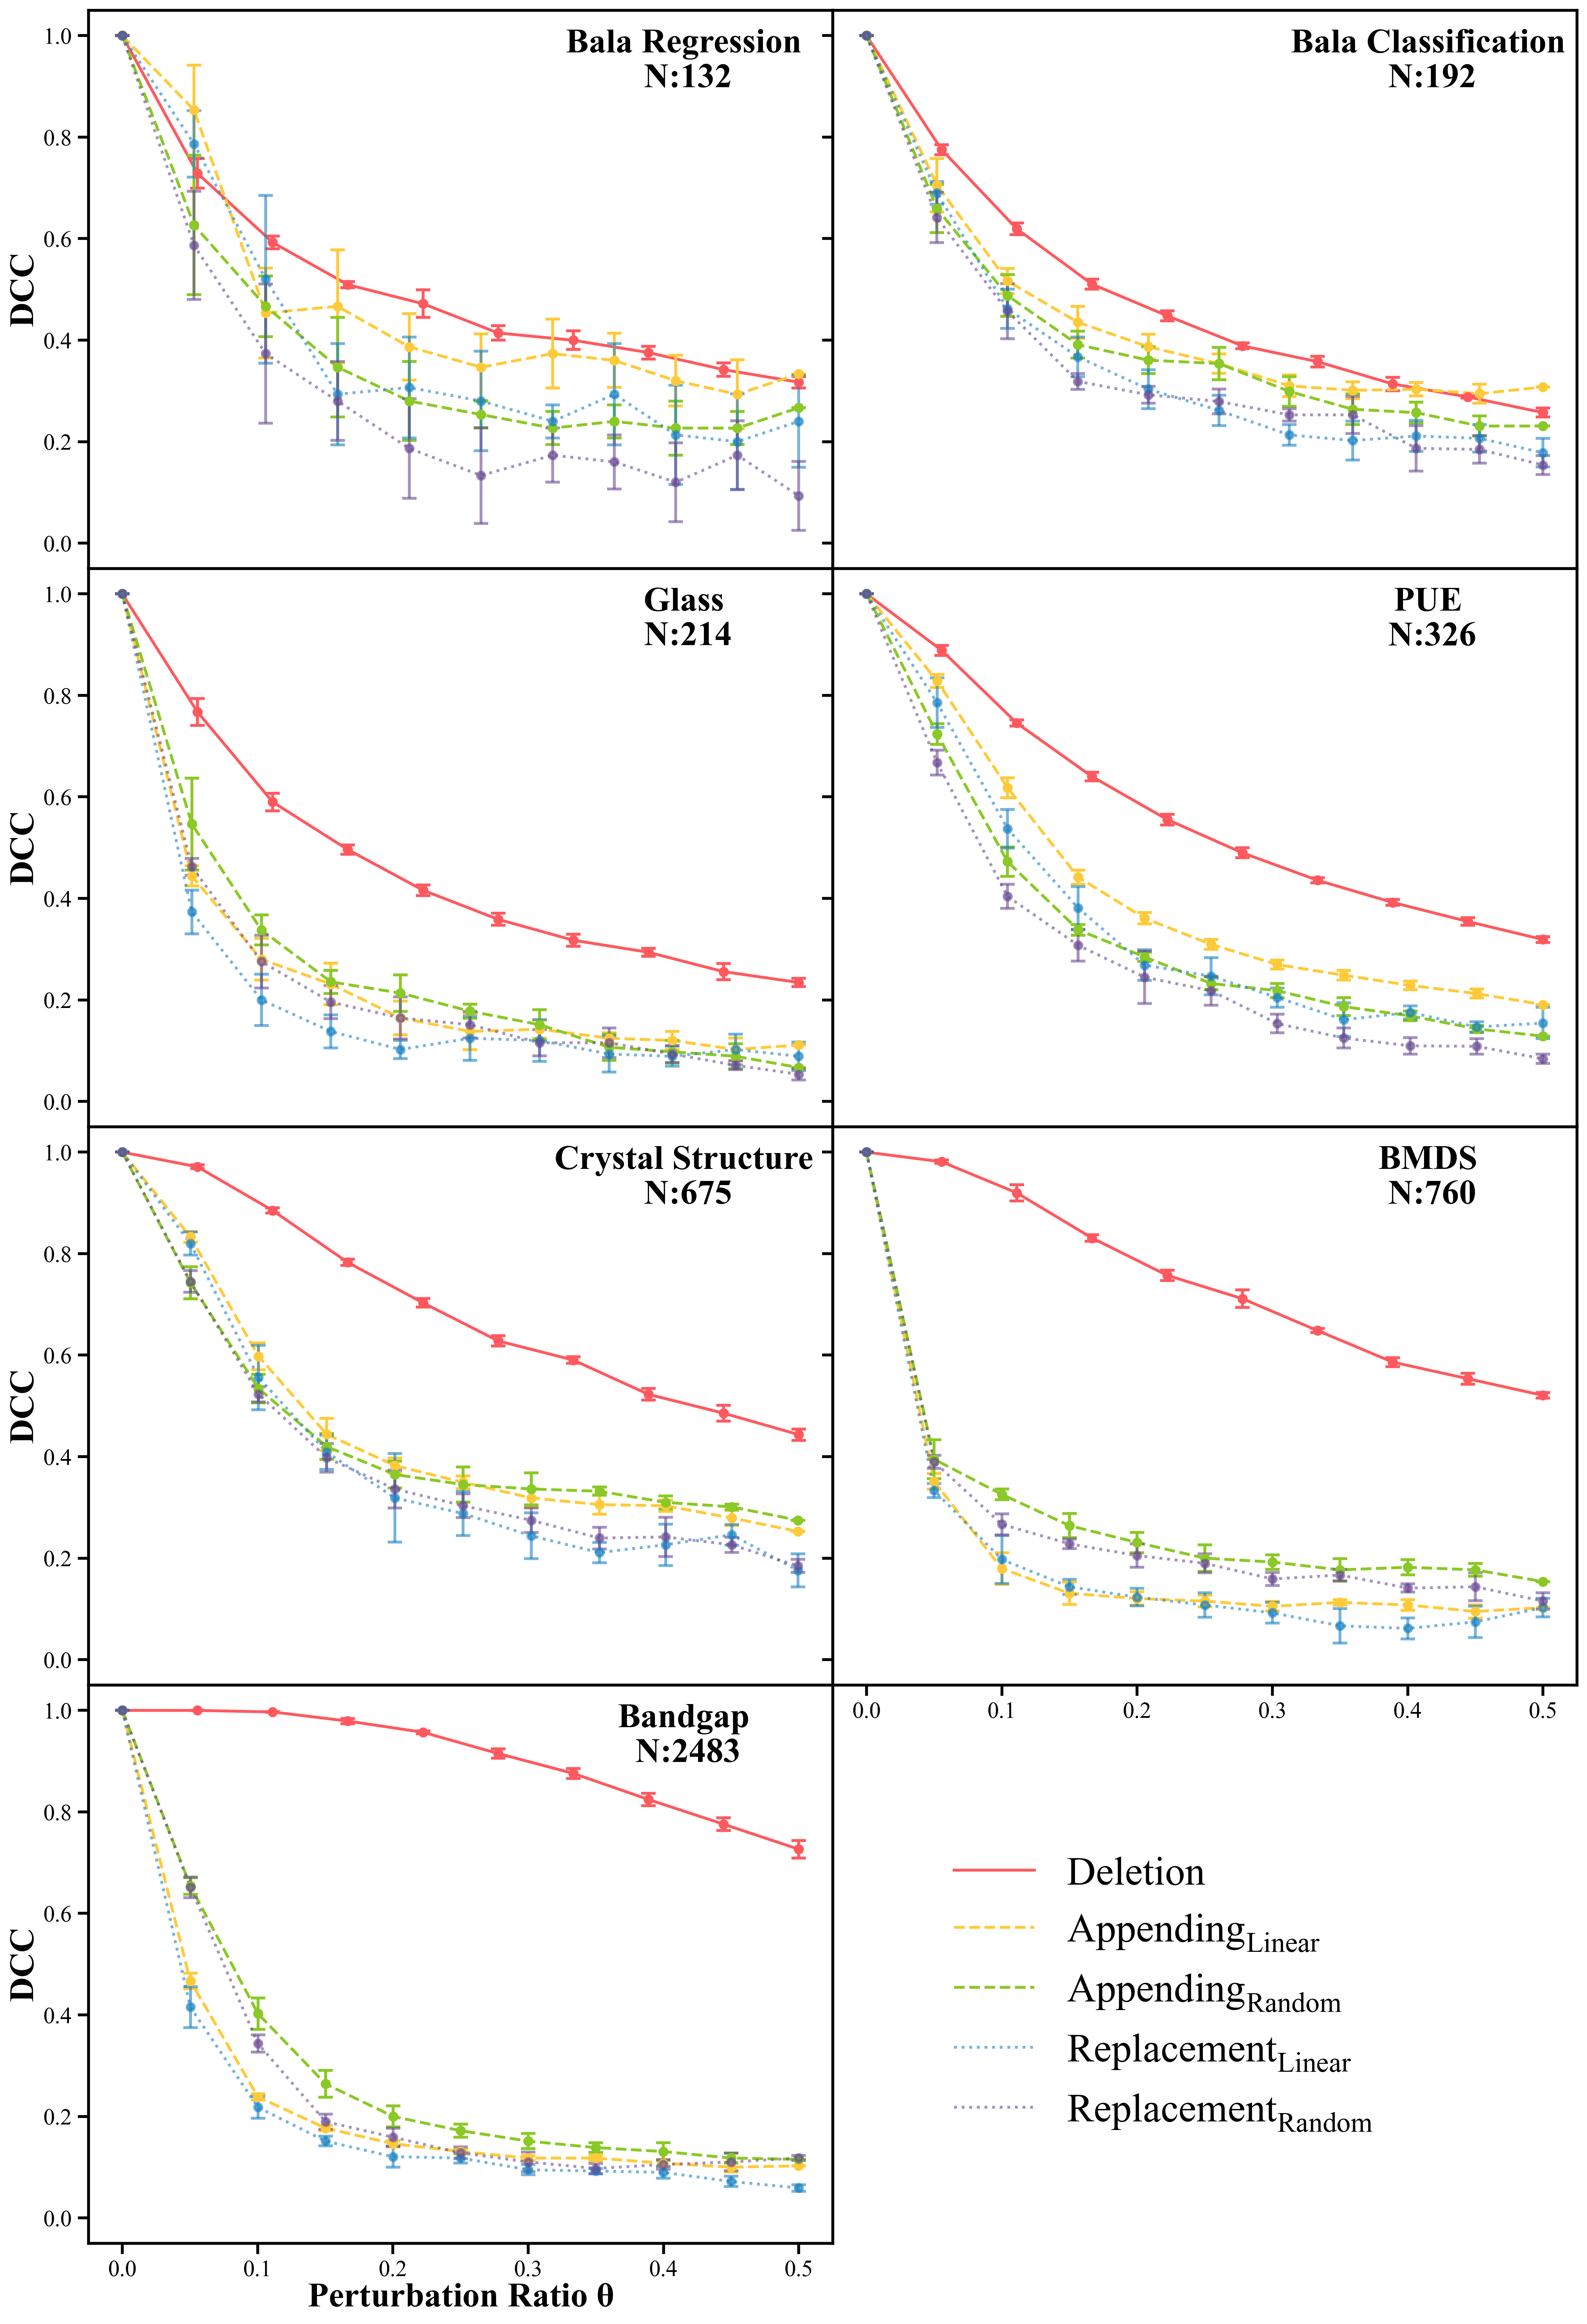

<Figure size 3000x2400 with 0 Axes>

<Figure size 3000x2400 with 0 Axes>

<Figure size 3000x2400 with 0 Axes>

<Figure size 3000x2400 with 0 Axes>

<Figure size 3000x2400 with 0 Axes>

<Figure size 3000x2400 with 0 Axes>

<Figure size 3000x2400 with 0 Axes>

In [ ]:
datasets = dataset_dir.glob("*.csv")
# sort the datasets by its data samples
import pandas as pd

datasets = sorted(datasets, key=lambda x: pd.read_csv(x).shape[0])
print(f"Found {len(list(datasets))} datasets in {dataset_dir}")
cols = 2
rows = 4
print(f"Rows: {rows}, Cols: {cols}")
fig, axes = plt.subplots(
    nrows=rows,
    ncols=cols,
    figsize=(8 * cols, 6 * rows),
    sharey=True,
    gridspec_kw={"hspace": 0, "wspace": 0},
)
axes = axes.flatten()
axes[0].set_ylim(-0.05, 1.05)
idx = 0
for d in datasets:

    df = pd.read_csv(d)
    target_cols = dataset_config[d.name]["target_cols"]
    X = df.drop(columns=target_cols)
    for col in target_cols:
        y = df[col]
        data = pd.concat([X, y], axis=1)
        show_xlabel = idx // cols == rows - 1
        show_ylabel = idx % cols == 0
        ax = axes[idx]
        (
            auc_scores,
            dcc_scores_drop,
            dcc_scores_append_randoms,
            dcc_scores_append_linears,
            dcc_scores_replace_randoms,
            dcc_scores_replace_linears,
        ) = exp(data, d.name, ax, show_xlabel=show_xlabel, show_ylabel=show_ylabel)
        results[f"{d.name}_{col}"]["auc_scores"] = {
            "mean": np.mean(auc_scores),
            "std": np.std(auc_scores),
        }
        results[f"{d.name}_{col}"]["dcc_scores_drop"] = dcc_scores_drop
        results[f"{d.name}_{col}"][
            "dcc_scores_append_randoms"
        ] = dcc_scores_append_randoms
        results[f"{d.name}_{col}"][
            "dcc_scores_append_linears"
        ] = dcc_scores_append_linears
        results[f"{d.name}_{col}"][
            "dcc_scores_replace_randoms"
        ] = dcc_scores_replace_randoms
        results[f"{d.name}_{col}"][
            "dcc_scores_replace_linears"
        ] = dcc_scores_replace_linears
        # get corr of y with each column in X
        corr = data.corr()[col].drop(col)
        # sum the absolute value of the corr
        mean_corr = np.mean(np.abs(corr))
        results[f"{d.name}_{col}"]["mean_corr"] = mean_corr
        idx += 1
fig.subplots_adjust(
    left=0.05,
    right=0.95,
    top=0.95,
    bottom=0.05,
    hspace=0.15,
    wspace=0.1,
)
# delete the empty subplots

for i in range(idx, len(axes)):
    fig.delaxes(axes[i])

# add legend at bottom center

handles, labels = axes[0].get_legend_handles_labels()
labels = [
    "Deletion",
    r"$Appending_{Linear}$",
    r"$Appending_{Random}$",
    r"$Replacement_{Linear}$",
    r"$Replacement_{Random}$",
]
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.7, 0.08),
    ncol=1,
    fontsize=28,
    frameon=False,
)

plt.savefig("plots/all_dcc_vs_theta-spearman.png", dpi=300, bbox_inches="tight")

In [ ]:
# save the results
import pickle

with open("results/dcc_vs_theta_results-spearman.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
import pickle
results = {}

with open("results/dcc_vs_theta_results-spearman.pkl", "rb") as f:
    results = pickle.load(f)

print("Results loaded successfully.")
results

Results loaded successfully.


defaultdict(dict,
            {'Bala_classification_dataset.csv_Formability': {'model_scores': {'type': 'classification',
               'scores': array([[0.97435897, 0.92307692, 0.86842105, 0.92105263, 0.78947368],
                      [0.87179487, 0.92307692, 0.89473684, 0.94736842, 0.84210526],
                      [0.92307692, 0.84615385, 0.86842105, 0.94736842, 0.89473684],
                      [0.94871795, 0.79487179, 0.94736842, 0.84210526, 0.97368421],
                      [0.8974359 , 0.82051282, 0.89473684, 0.89473684, 0.92105263],
                      [0.94871795, 0.82051282, 0.89473684, 1.        , 0.76315789],
                      [0.79487179, 0.92307692, 0.89473684, 0.81578947, 0.89473684],
                      [0.8974359 , 0.84615385, 0.97368421, 0.89473684, 0.89473684],
                      [0.8974359 , 0.94871795, 0.84210526, 0.89473684, 0.86842105],
                      [0.84615385, 0.87179487, 0.94736842, 0.94736842, 0.92105263],
                      [0.871

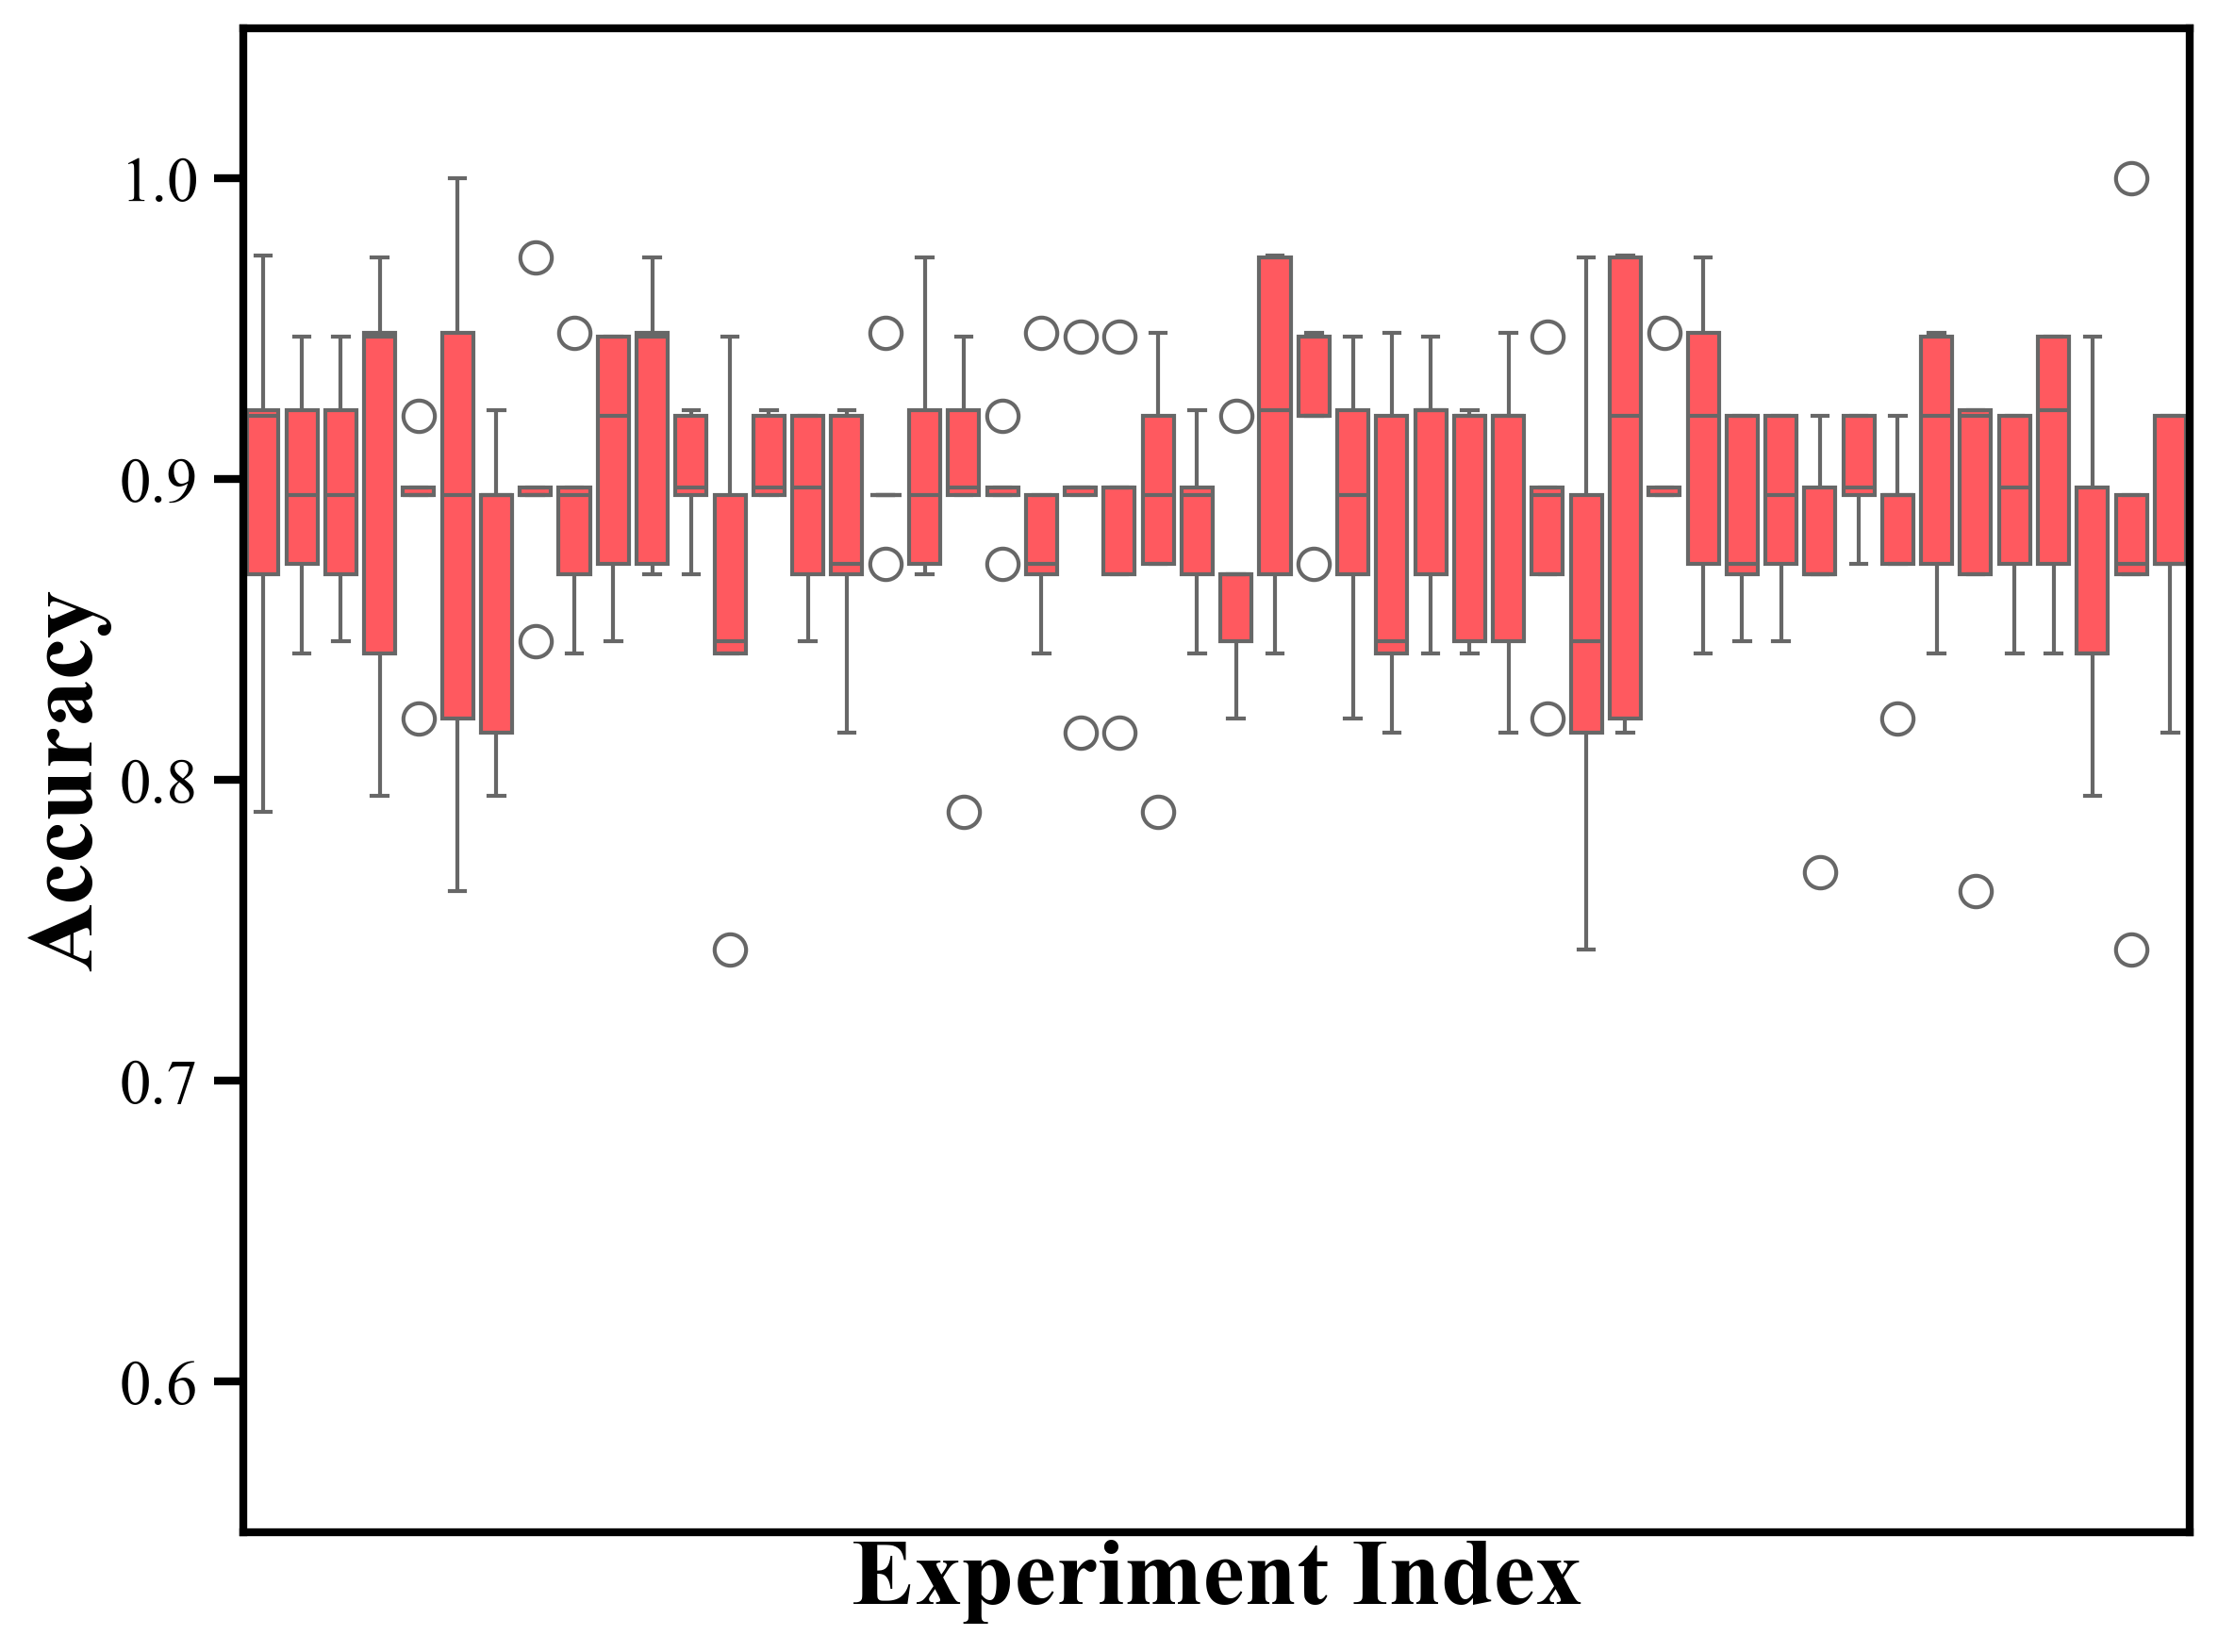

In [ ]:
a = results["Bala_classification_dataset.csv_Formability"]["model_scores"]["scores"]

# 转为长格式：每行有 5 个数，共 500 个点
df = pd.DataFrame(a)
df_long = df.melt(ignore_index=False, var_name="col", value_name="value")
df_long["row"] = df_long.index  # 添加原始行索引

# 使用 seaborn 画 boxplot，x 为 row（行号），y 为对应的值
plt.figure(figsize=(8, 6))
sns.boxplot(x="row", y="value", data=df_long, color="#ff595f", saturation=1.0)
plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.xticks(ticks=[])
plt.ylim(0.55, 1.05)
plt.tight_layout()
plt.show()

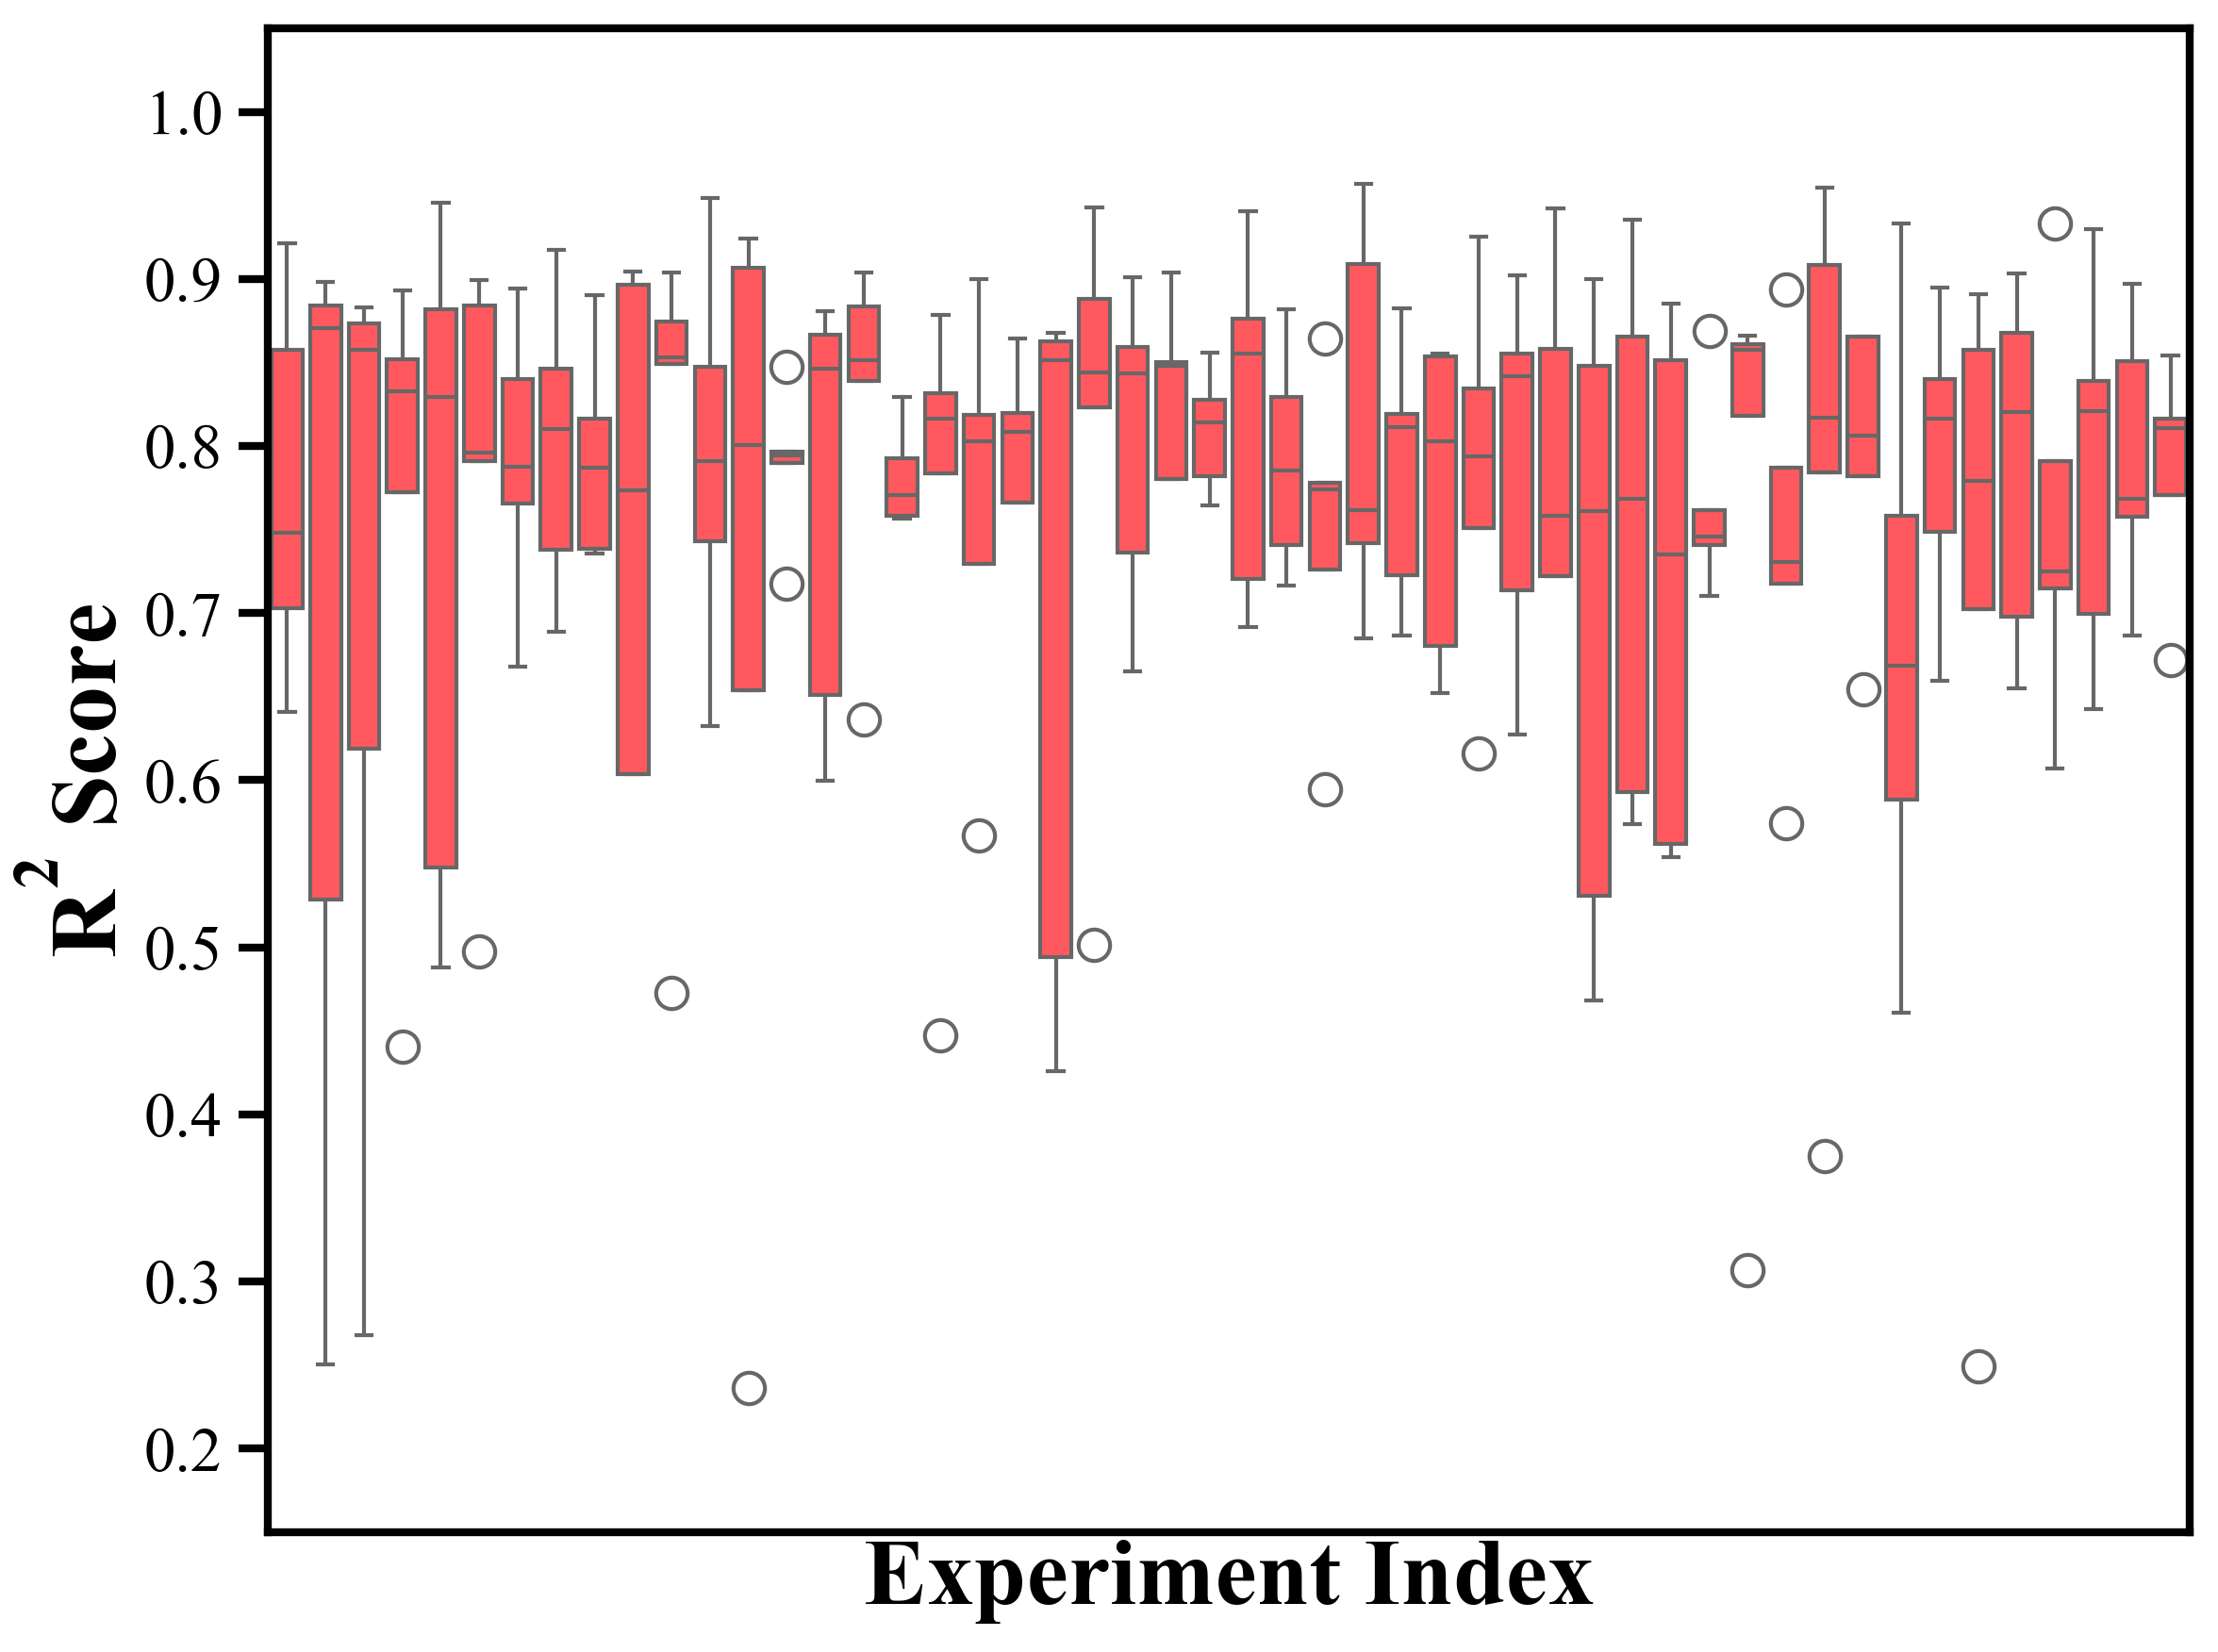

In [ ]:
a = results["Bala_regression_dataset.csv_Ferroelectric_Tc_in_Kelvin"]["model_scores"][
    "scores"
]

# 转为长格式：每行有 5 个数，共 500 个点
df = pd.DataFrame(a)
df_long = df.melt(ignore_index=False, var_name="col", value_name="value")
df_long["row"] = df_long.index  # 添加原始行索引

# 使用 seaborn 画 boxplot，x 为 row（行号），y 为对应的值
plt.figure(figsize=(8, 6))
sns.boxplot(x="row", y="value", data=df_long, color="#ff595f", saturation=1.0)
plt.xlabel("Experiment Index")
plt.ylabel("$R^2$ Score")
plt.xticks(ticks=[])
plt.ylim(0.15, 1.05)
plt.tight_layout()
plt.show()

In [ ]:
all_model_scores = []
all_auc_scores = []
all_mean_corr = []
all_model_stds = []
all_dcc_scores_drop = []
all_dcc_scores_append_randoms = []
all_dcc_scores_append_linears = []
all_dcc_scores_replace_randoms = []
all_dcc_scores_replace_linears = []

task = None # "regression"  # or "classification"


for k, v in results.items():
    task_type = v["model_scores"]["type"]
    if task is None or task_type == task:
        print(
            f"Dataset: {k}, Model Scores: {v['model_scores']['mean']}, AUC Scores: {v['auc_scores']['mean']}, Mean Corr: {v['mean_corr']}"
        )
        all_model_scores.append(v["model_scores"]["mean"])
        all_auc_scores.append(v["auc_scores"]["mean"])
        all_mean_corr.append(v["mean_corr"])
        all_model_stds.append(v["model_scores"]["std"])
        all_dcc_scores_drop.append(v["dcc_scores_drop"][1])
        all_dcc_scores_append_randoms.append(v["dcc_scores_append_randoms"][1])
        all_dcc_scores_append_linears.append(v["dcc_scores_append_linears"][1])
        all_dcc_scores_replace_randoms.append(v["dcc_scores_replace_randoms"][1])
        all_dcc_scores_replace_linears.append(v["dcc_scores_replace_linears"][1])

Dataset: Bala_classification_dataset.csv_Formability, Model Scores: 0.8907881241565452, AUC Scores: 0.24053479853479853, Mean Corr: 0.20155020739663987
Dataset: Bala_regression_dataset.csv_Ferroelectric_Tc_in_Kelvin, Model Scores: 0.7534301406963405, AUC Scores: 0.24956296296296293, Mean Corr: 0.27656971912032574
Dataset: bandgap.csv_target, Model Scores: 0.7989884301175258, AUC Scores: 0.45483475783475785, Mean Corr: 0.33030408490694346
Dataset: BMDS_data.csv_soc_bandgap, Model Scores: 0.9728962033079159, AUC Scores: 0.3749301994301994, Mean Corr: 0.30838869461375135
Dataset: Crystal_structure.csv_Lowest distortion, Model Scores: 0.7758518518518518, AUC Scores: 0.3494676434676435, Mean Corr: 0.1536291339035053
Dataset: Glass.csv_Type of glass, Model Scores: 0.7907397563676632, AUC Scores: 0.2284864197530864, Mean Corr: 0.3266585291839352
Dataset: PUE.csv_logYM, Model Scores: 0.8218482447319777, AUC Scores: 0.2867201058201058, Mean Corr: 0.3462956540121301


In [ ]:
# calculate the correlation
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr


# # all_auc_scores * all_mean_corr
# all_scores = []
# for i in range(len(all_auc_scores)):
#     all_scores.append(all_auc_scores[i] * all_mean_corr[i])
# print("相关性分析：model scores vs all scores")
# correlation, p_value = pearsonr(all_model_scores, all_scores)
# print(f"Correlation: {correlation}, p-value: {p_value}")

# print('相关性分析：model stds vs all auc scores')
# correlation, p_value = pearsonr(all_model_stds, all_auc_scores)
# print(f"Correlation: {correlation}, p-value: {p_value}")

print("相关性分析：model stds vs all dcc scores drop")
correlation, p_value = pearsonr(all_model_stds, all_dcc_scores_drop)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model stds vs all dcc scores append randoms")
correlation, p_value = pearsonr(all_model_stds, all_dcc_scores_append_randoms)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model stds vs all dcc scores append linears")
correlation, p_value = pearsonr(all_model_stds, all_dcc_scores_append_linears)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model stds vs all dcc scores replace randoms")
correlation, p_value = pearsonr(all_model_stds, all_dcc_scores_replace_randoms)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model stds vs all dcc scores replace linears")
correlation, p_value = pearsonr(all_model_stds, all_dcc_scores_replace_linears)

相关性分析：model stds vs all dcc scores drop
Correlation: -0.675936698235017, p-value: 0.09553170698372862
相关性分析：model stds vs all dcc scores append randoms
Correlation: 0.12551184405116378, p-value: 0.7885988155881999
相关性分析：model stds vs all dcc scores append linears
Correlation: 0.5273088629061573, p-value: 0.2238897478767839
相关性分析：model stds vs all dcc scores replace randoms
Correlation: 0.028743575625602896, p-value: 0.9512235456888405
相关性分析：model stds vs all dcc scores replace linears


In [ ]:
print("相关性分析：model stds vs all dcc scores drop")
correlation, p_value = spearmanr(all_model_stds, all_dcc_scores_drop)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model stds vs all dcc scores append randoms")
correlation, p_value = spearmanr(all_model_stds, all_dcc_scores_append_randoms)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model stds vs all dcc scores append linears")
correlation, p_value = spearmanr(all_model_stds, all_dcc_scores_append_linears)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model stds vs all dcc scores replace randoms")
correlation, p_value = spearmanr(all_model_stds, all_dcc_scores_replace_randoms)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model stds vs all dcc scores replace linears")
correlation, p_value = spearmanr(all_model_stds, all_dcc_scores_replace_linears)
print(f"Correlation: {correlation}, p-value: {p_value}")

相关性分析：model stds vs all dcc scores drop
Correlation: -0.7857142857142859, p-value: 0.03623846267982713
相关性分析：model stds vs all dcc scores append randoms
Correlation: 0.07142857142857144, p-value: 0.8790481931481541
相关性分析：model stds vs all dcc scores append linears
Correlation: 0.5357142857142858, p-value: 0.21521745567801273
相关性分析：model stds vs all dcc scores replace randoms
Correlation: 0.03571428571428572, p-value: 0.9394082054712856
相关性分析：model stds vs all dcc scores replace linears
Correlation: 0.3571428571428572, p-value: 0.4316113520383278


In [ ]:
print("相关性分析：model scores vs all dcc scores drop")
correlation, p_value = pearsonr(all_model_scores, all_dcc_scores_drop)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model scores vs all dcc scores append randoms")
correlation, p_value = pearsonr(all_model_scores, all_dcc_scores_append_randoms)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model scores vs all dcc scores append linears")
correlation, p_value = pearsonr(all_model_scores, all_dcc_scores_append_linears)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model scores vs all dcc scores replace randoms")
correlation, p_value = pearsonr(all_model_scores, all_dcc_scores_replace_randoms)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model scores vs all dcc scores replace linears")
correlation, p_value = pearsonr(all_model_scores, all_dcc_scores_replace_linears)
print(f"Correlation: {correlation}, p-value: {p_value}")

相关性分析：model scores vs all dcc scores drop
Correlation: 0.2888063938385953, p-value: 0.5298960636458355
相关性分析：model scores vs all dcc scores append randoms
Correlation: -0.6560330249888019, p-value: 0.10955758478077833
相关性分析：model scores vs all dcc scores append linears
Correlation: -0.5326914414216812, p-value: 0.21831761219426843
相关性分析：model scores vs all dcc scores replace randoms
Correlation: -0.5419790922235468, p-value: 0.20885952524132442
相关性分析：model scores vs all dcc scores replace linears
Correlation: -0.4567279957486118, p-value: 0.30290779607408547


In [ ]:
print("相关性分析：model scores vs all dcc scores drop")
correlation, p_value = spearmanr(all_model_scores, all_dcc_scores_drop)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model scores vs all dcc scores append randoms")
correlation, p_value = spearmanr(all_model_scores, all_dcc_scores_append_randoms)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model scores vs all dcc scores append linears")
correlation, p_value = spearmanr(all_model_scores, all_dcc_scores_append_linears)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model scores vs all dcc scores replace randoms")
correlation, p_value = spearmanr(all_model_scores, all_dcc_scores_replace_randoms)
print(f"Correlation: {correlation}, p-value: {p_value}")
print("相关性分析：model scores vs all dcc scores replace linears")
correlation, p_value = spearmanr(all_model_scores, all_dcc_scores_replace_linears)
print(f"Correlation: {correlation}, p-value: {p_value}")

相关性分析：model scores vs all dcc scores drop
Correlation: 0.4642857142857144, p-value: 0.2939341076002517
相关性分析：model scores vs all dcc scores append randoms
Correlation: -0.21428571428571433, p-value: 0.6445115810207203
相关性分析：model scores vs all dcc scores append linears
Correlation: -0.6785714285714287, p-value: 0.0937502539598313
相关性分析：model scores vs all dcc scores replace randoms
Correlation: -0.28571428571428575, p-value: 0.5345092286010406
相关性分析：model scores vs all dcc scores replace linears
Correlation: -0.642857142857143, p-value: 0.11939237342741094


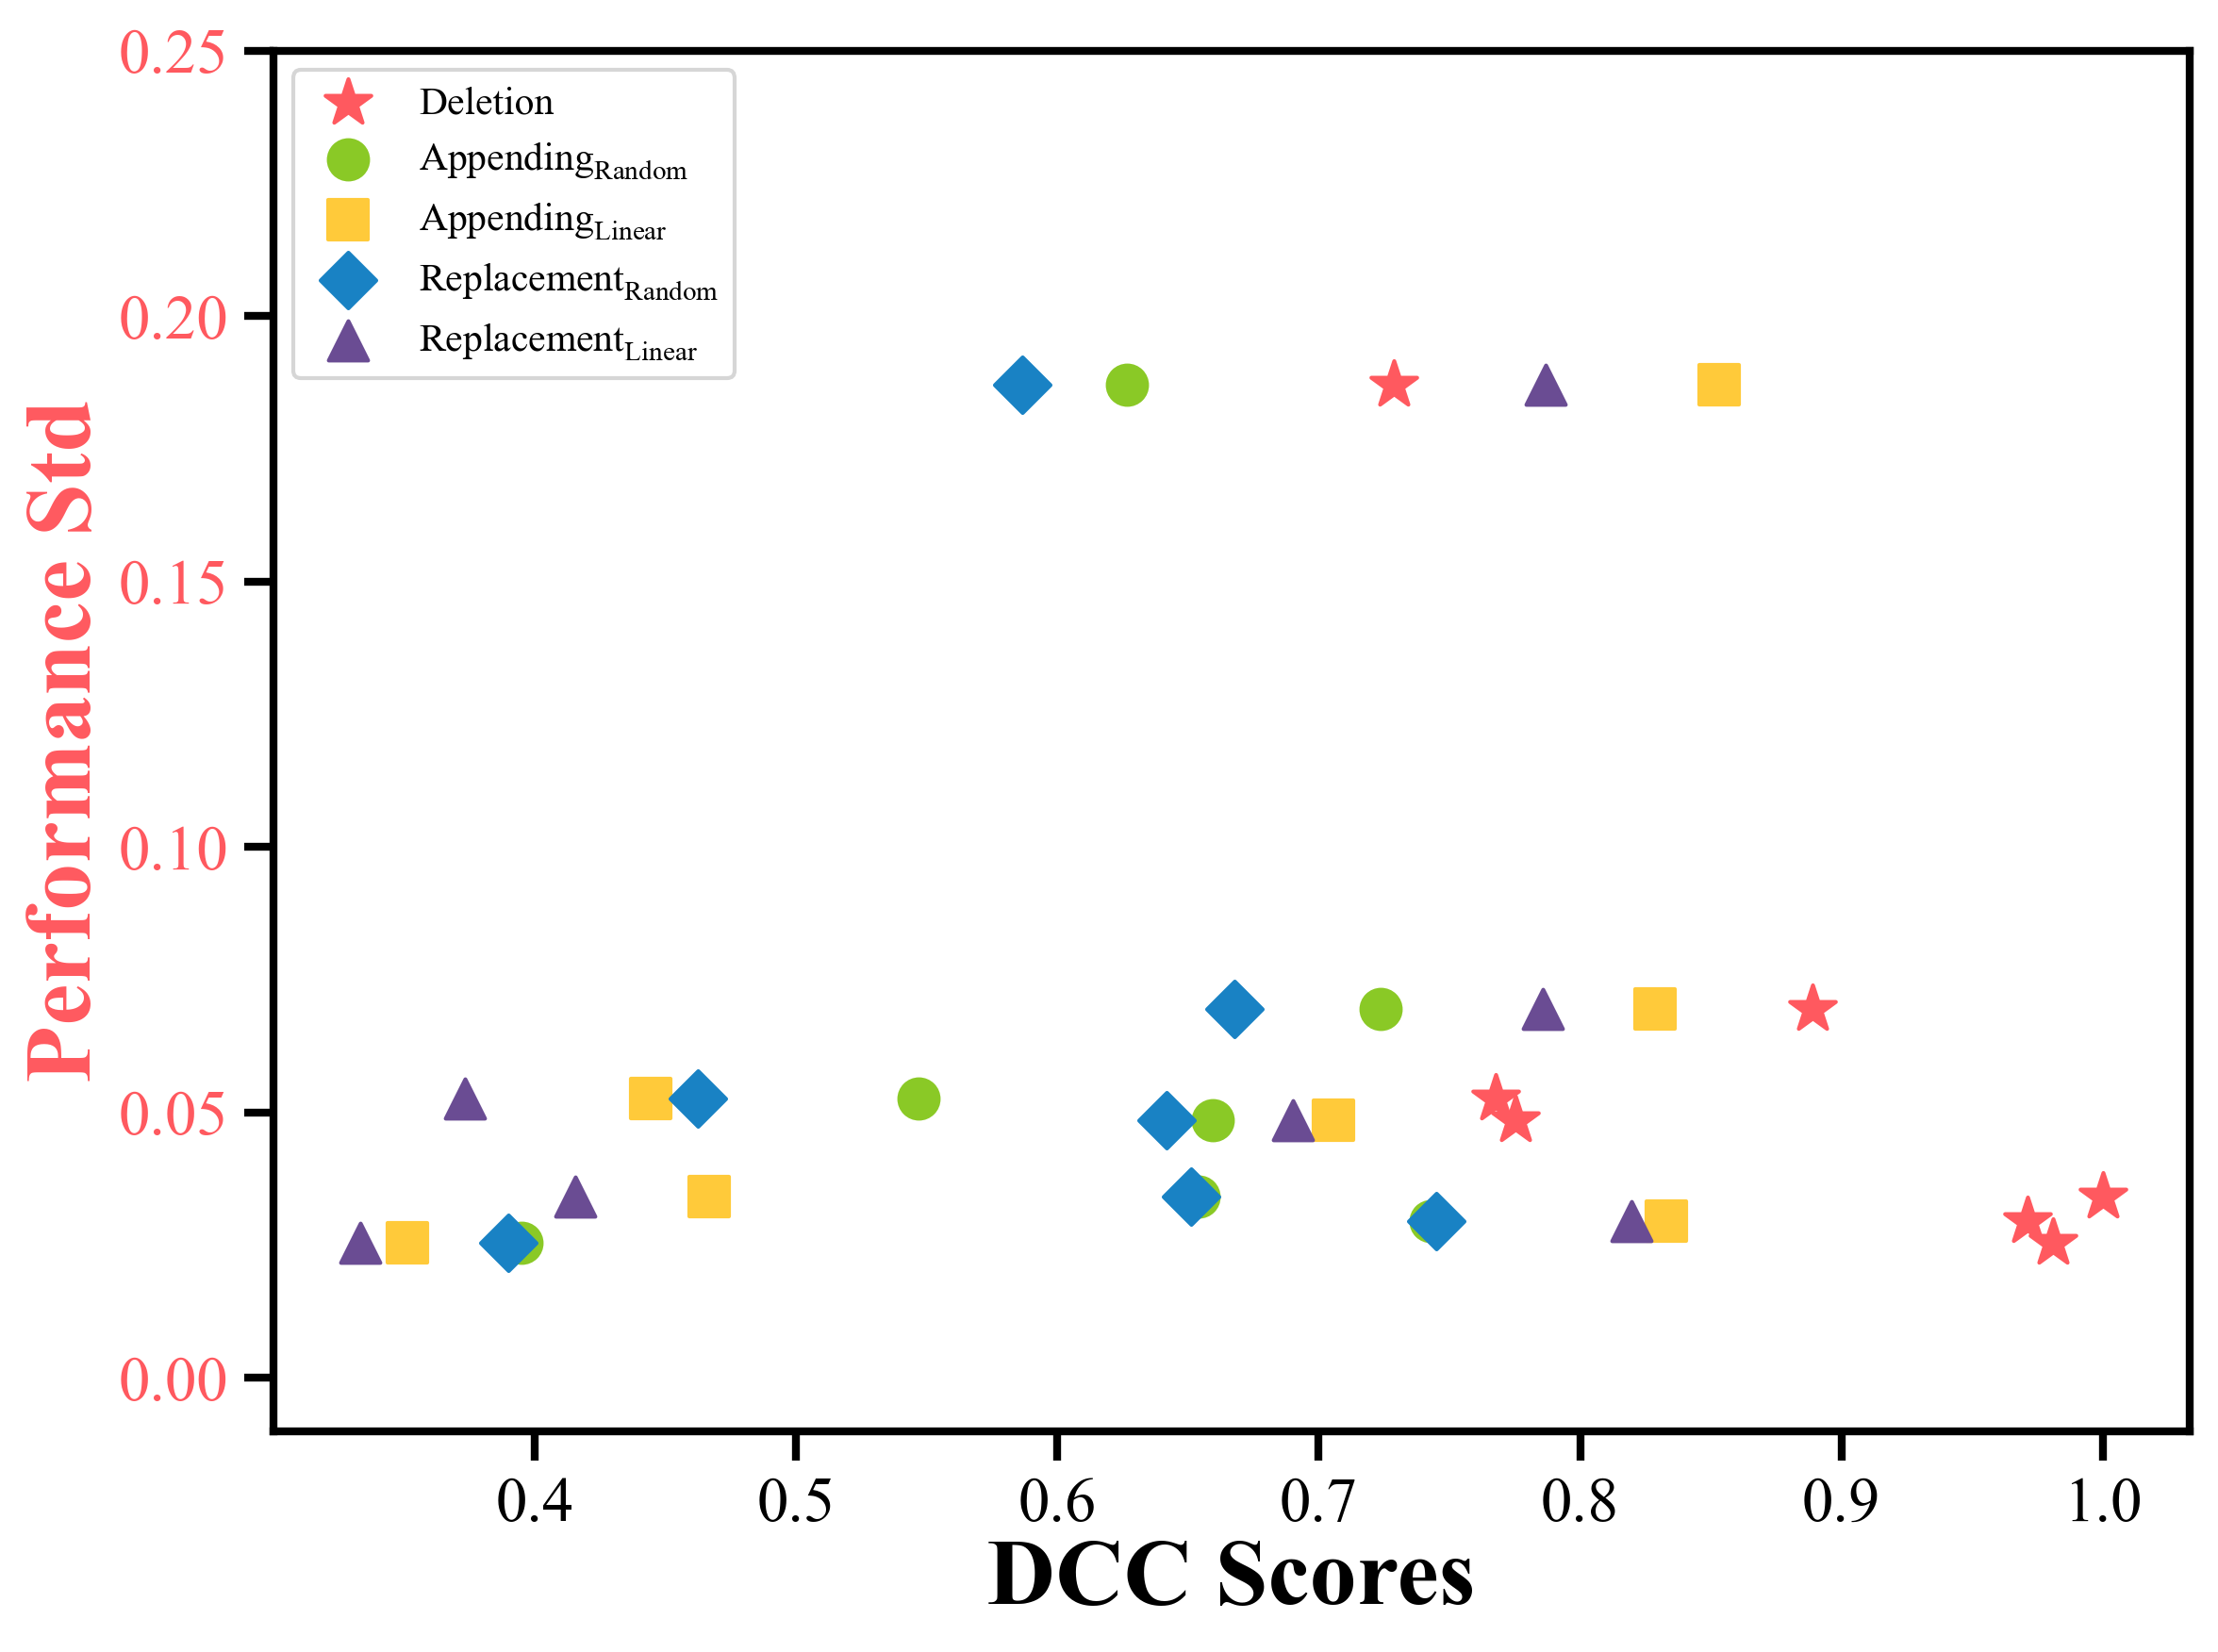

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Primary y-axis: DCC Scores
scatter1 = ax1.scatter(
    x=all_dcc_scores_drop, y=all_model_stds, s=150, color="#ff595f", marker="*",
)
scatter2 = ax1.scatter(
    x=all_dcc_scores_append_randoms, y=all_model_stds, s=100, color="#8ac926", marker="o", 
)
scatter3 = ax1.scatter(
    x=all_dcc_scores_append_linears, y=all_model_stds, s=100, color="#ffca3a", marker="s",
)
scatter4 = ax1.scatter(
    x=all_dcc_scores_replace_randoms, y=all_model_stds, s=100, color="#1982c4", marker="D",
)
scatter5 = ax1.scatter(
    x=all_dcc_scores_replace_linears, y=all_model_stds, s=100, color="#6a4c93", marker="^",
)
ax1.set_xlabel("DCC Scores")
ax1.set_ylabel("Performance Std", color="#ff595f")
ax1.tick_params(axis="y", labelcolor="#ff595f")
ax1.set_ylim(-0.01, 0.25)

# # Secondary y-axis: Model Performance Mean
# ax2 = ax1.twinx()
# scatter2 = ax2.scatter(
#     x=all_dcc_scores_drop,
#     y=all_model_scores,
#     s=100,
#     color="#6a4c93",
#     marker="^",
#     label="Model Performance",
# )
# ax2.set_ylabel("Performance Mean", color="#6a4c93")
# ax2.tick_params(axis="y", labelcolor="#6a4c93")
# ax2.set_ylim(0.45, 1.05)

plt.legend(
    ["Deletion", r"$Appending_{Random}$", r"$Appending_{Linear}$", r"$Replacement_{Random}$", r"$Replacement_{Linear}$"],
    loc="upper left",
    bbox_to_anchor=(0.0, 1.0),
    fontsize=10,
)
plt.tight_layout()

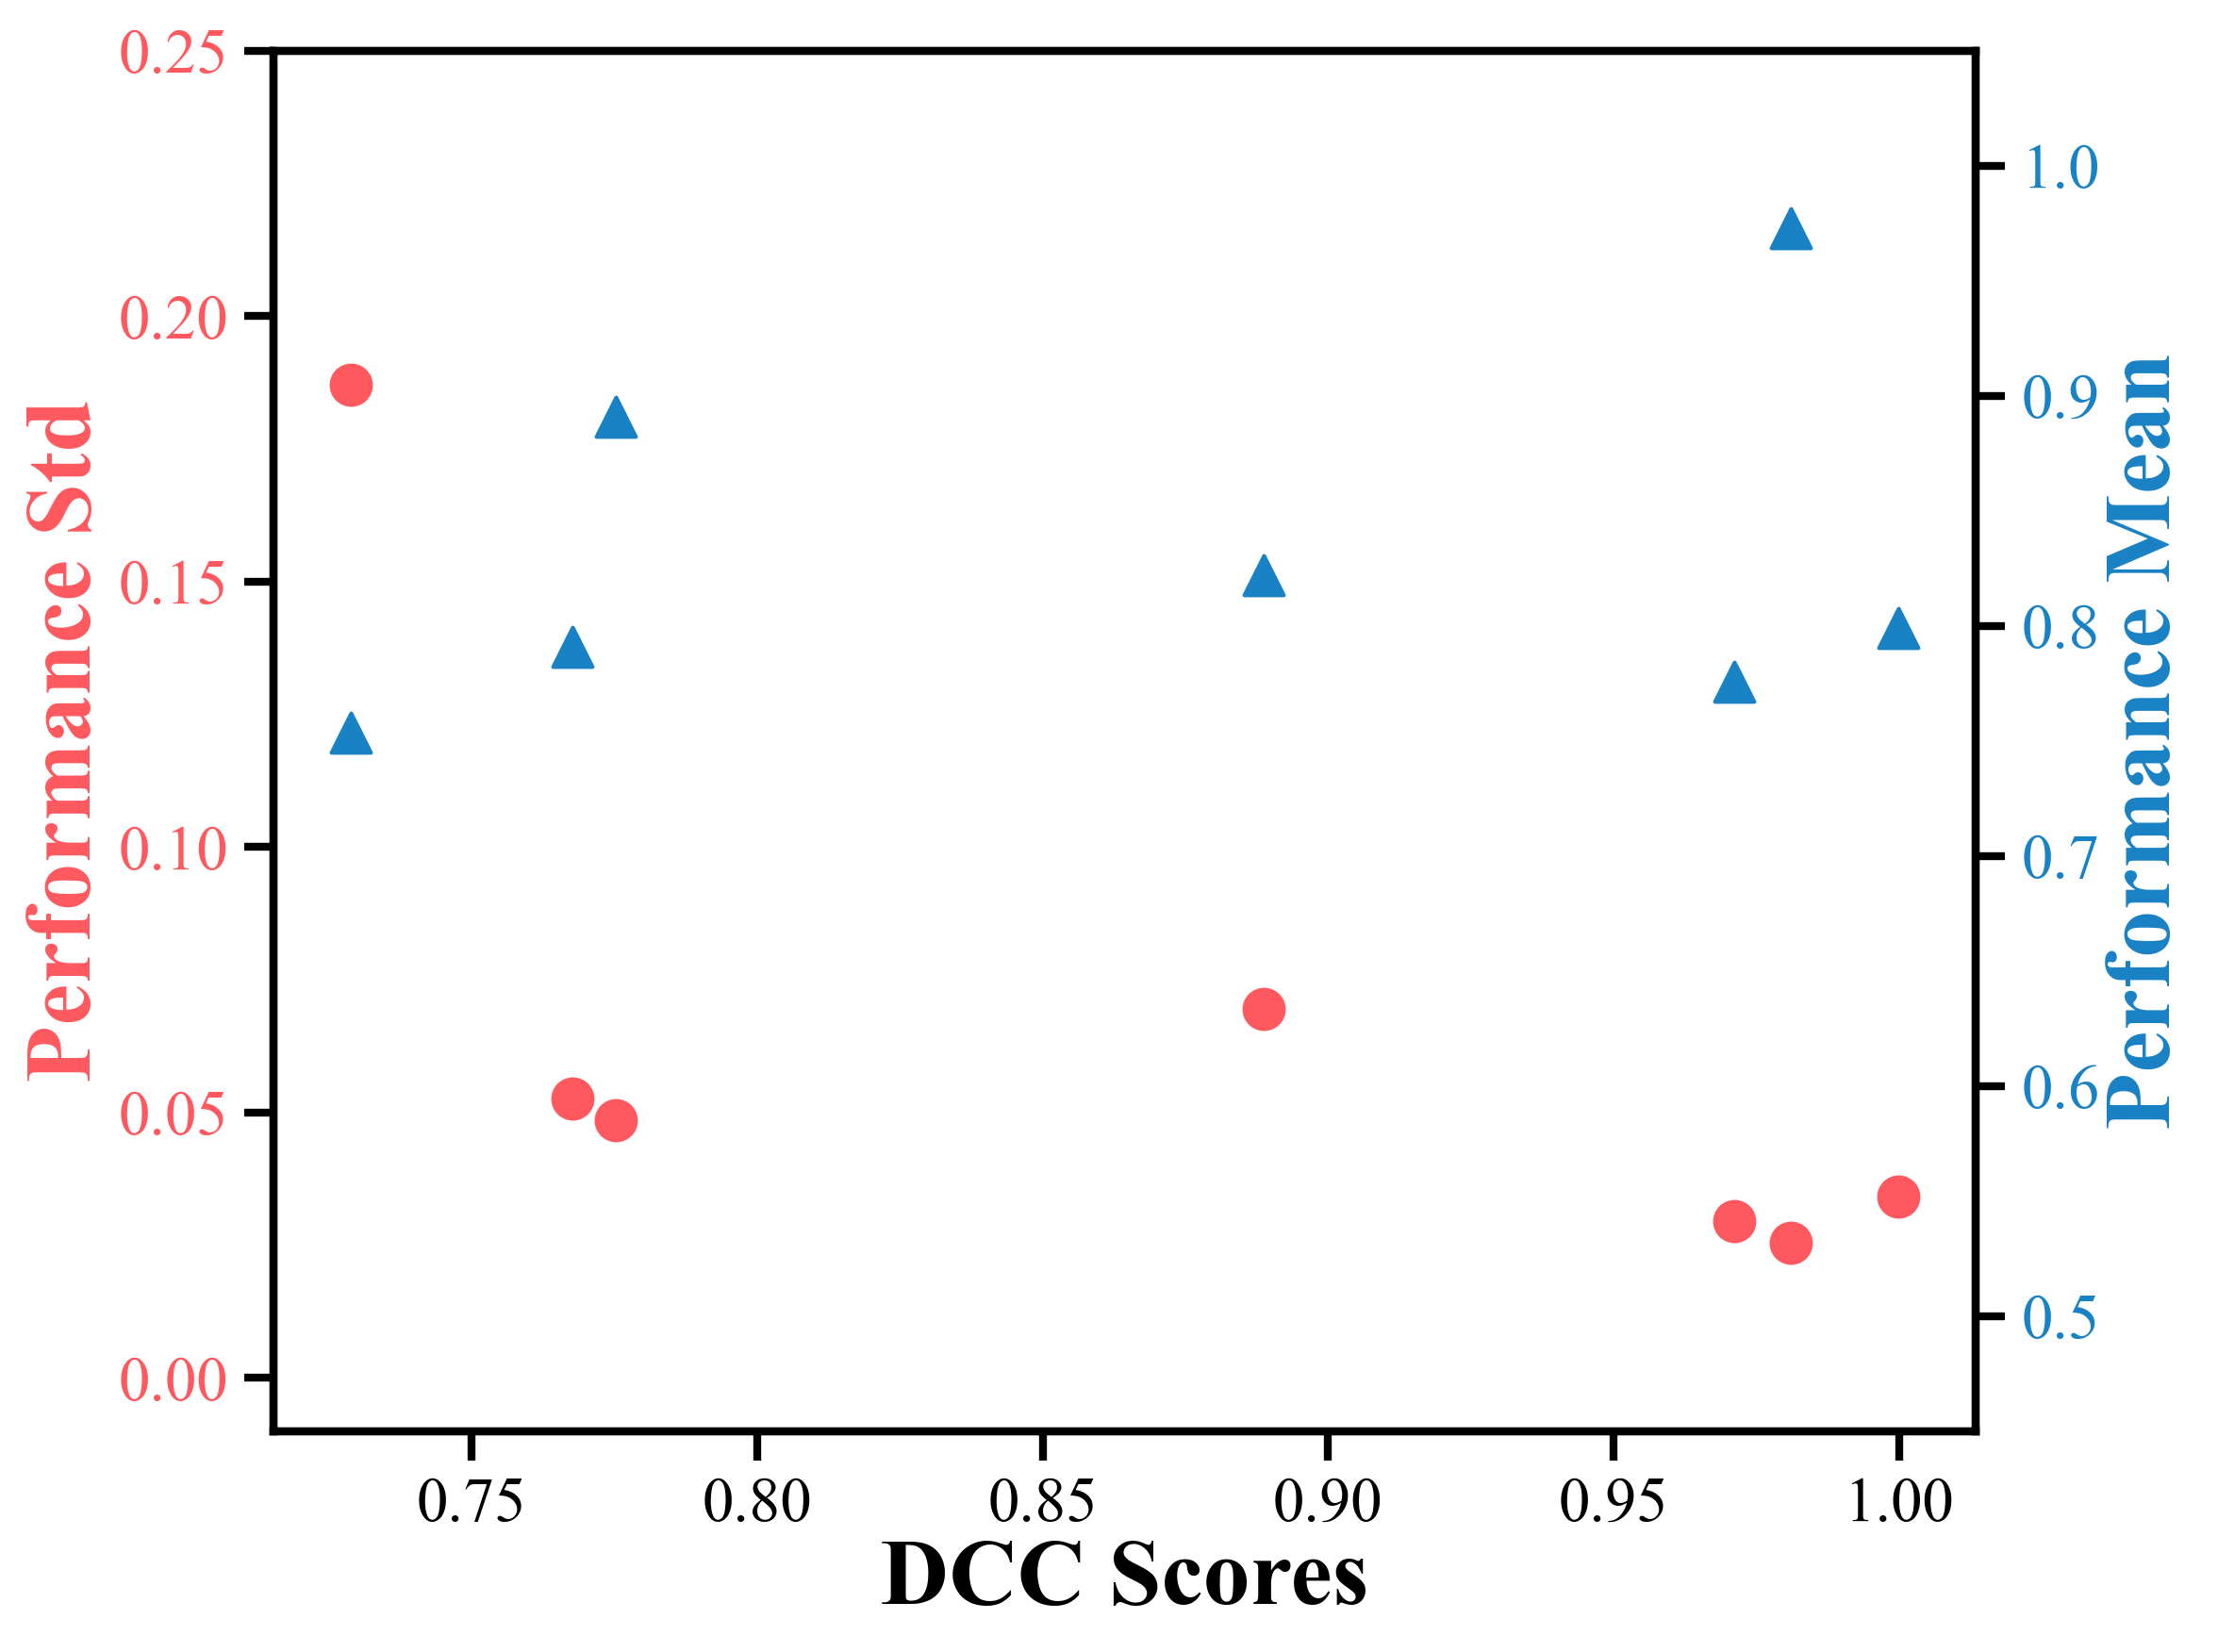

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Primary y-axis: DCC Scores
scatter1 = ax1.scatter(
    x=all_dcc_scores_drop, y=all_model_stds, s=100, color="#ff595f", label="DCC Scores Drop"
)
ax1.set_xlabel("DCC Scores")
ax1.set_ylabel("Performance Std", color="#ff595f")
ax1.tick_params(axis="y", labelcolor="#ff595f")
ax1.set_ylim(-0.01, 0.25)

# Secondary y-axis: Model Performance Mean
ax2 = ax1.twinx()
scatter2 = ax2.scatter(
    x=all_dcc_scores_drop,
    y=all_model_scores,
    s=100,
    color="#1982c4",
    marker="^",
    label="Model Performance",
)
ax2.set_ylabel("Performance Mean", color="#1982c4")
ax2.tick_params(axis="y", labelcolor="#1982c4")
ax2.set_ylim(0.45, 1.05)

plt.tight_layout()